In [1]:
%%capture --no-display
!pip install jupyterlab_execute_time

In [2]:
import npu

# vector length; must be divisible by 4
vector_size = 128

Create app builder

In [3]:
from npu.build.kernel import Kernel
from npu.build.appbuilder import AppBuilder
import numpy as np
from npu.build.itkernel import ITWrite
from npu.build.mtkernel import MTSplit, MTConcat
from vector_add import VectorAdd1Buf

class SimpleApplication(AppBuilder):

    def __init__(self):
        self.kernel = [VectorAdd1Buf() for _ in range(4)]
        self.mtbsplit = MTSplit(4)
        self.mtbconcat = MTConcat()
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        nbytes = x_in.shape[0]

        kernel_outputs = [None] * 4

        inputs = self.mtbsplit(x_in)

        for i in range(4):
            kernel_outputs[i] = self.kernel[i](inputs[i], int(nbytes/8))

        mtbuffer_out = self.mtbconcat(kernel_outputs)
        
        _ = ITWrite(mtbuffer_out, bufref=x_out)

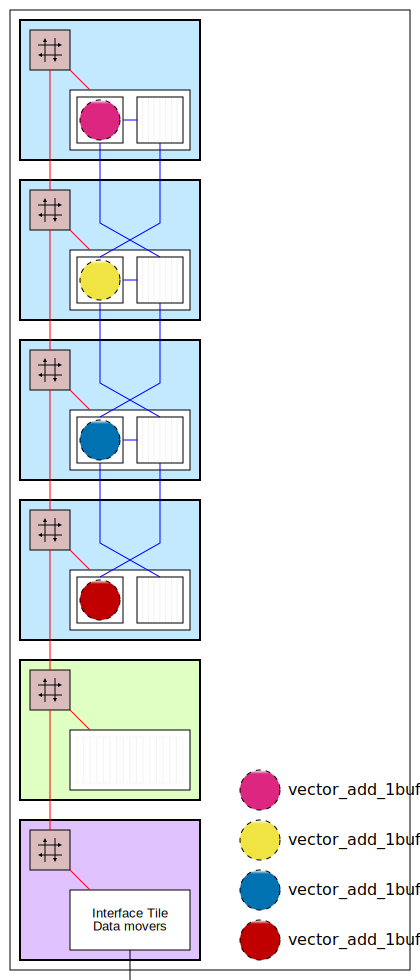

In [4]:
app_builder = SimpleApplication()

x_in = np.zeros(shape=(vector_size*2), dtype=np.uint8)
x_out = np.zeros(shape=(vector_size), dtype=np.uint8)

app_builder(x_in, x_out)

app_builder.display()
app_builder.save()

Build the app

In [5]:
app_builder.build(x_in, x_out)

Using cached vector_add_1buf kernel object file...
Building the xclbin...
Successfully Building Application... SimpleApplication.xclbin & SimpleApplication.seq delivered


In [6]:
app_builder.metadata

{'application': 'SimpleApplication',
 'kernels': OrderedDict([('itbuffer_0',
               {'name': 'itbuffer_0',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': None,
                  'direction': 'in',
                  'name': 'ITin',
                  'ctype': None,
                  'shape': (256,),
                  'dtype': 'uint8'},
                 'ITout': {'c_dtype': None,
                  'direction': 'out',
                  'name': 'ITout',
                  'ctype': None,
                  'shape': (256,),
                  'dtype': 'uint8'}},
                'shape': (256,),
                'dtype': 'uint8'}),
              ('itbuffer_1',
               {'name': 'itbuffer_1',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': 

Prep AppRunner and data

In [7]:
from npu.runtime import AppRunner

app = AppRunner('SimpleApplication.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input_vector = app.allocate(shape=(vector_size*2))
output_vector = app.allocate(shape=(vector_size))

# Load data
input_array = np.zeros(vector_size*2, dtype=np.uint8)
slice_size = int(vector_size/4)
for i in range(4):
    for j in range(slice_size):
        input_array[2*i*slice_size+j] = 1
        input_array[(2*i+1)*slice_size+j] = 2

input_vector[:] = input_array

Run the application

In [8]:
# Pass input_vector buffer to NPU
input_vector.sync_to_npu()

# Run app on NPU
app.call(input_vector, output_vector)

# Get results from NPU via output_vector buffer 
output_vector.sync_from_npu()

In [9]:
# Verify output
print(input_vector)
print(output_vector)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [10]:
del app